### Install and Import Third Party Dependencies

In [1]:
%pip install pandas numpy matplotlib seaborn scipy scikit-learn

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

### Initialize datasets and columns for outlier detection

In [3]:
# Load dataset (update the file path if needed)
df = pd.read_csv("data.csv")

# Select numeric columns for outlier detection
df_numeric = df.select_dtypes(include='number')

# Add the 'title' column to the numeric DataFrame
# df_numeric = pd.concat([df[['title']], df_numeric], axis=1)

# Display dataset info and summary
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20877 entries, 0 to 20876
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               20225 non-null  object 
 1   type                20877 non-null  object 
 2   genres              20530 non-null  object 
 3   releaseYear         20842 non-null  float64
 4   imdbId              19356 non-null  object 
 5   imdbAverageRating   19166 non-null  float64
 6   imdbNumVotes        19166 non-null  float64
 7   availableCountries  166 non-null    object 
dtypes: float64(3), object(5)
memory usage: 1.3+ MB
None
        releaseYear  imdbAverageRating  imdbNumVotes
count  20842.000000       19166.000000  1.916600e+04
mean    2013.250744           6.395393  3.169231e+04
std       14.315295           1.094817  1.202100e+05
min     1913.000000           1.200000  5.000000e+00
25%     2012.000000           5.700000  3.262500e+02
50%     2018.000000        

### Outliers Detected using Z-score

In [4]:
df_z = df_numeric

# Calculate the mean and standard deviation for 'imdbNumVotes'
mean_votes = df_z['imdbNumVotes'].mean()
std_votes = df_z['imdbNumVotes'].std()

# Calculate the Z-scores
df_z['z_score'] = (df_z['imdbNumVotes'] - mean_votes) / std_votes

# Define the threshold for identifying outliers
threshold = 3

# Identify outliers
df_z['is_outlier'] = np.abs(df_z['z_score']) > threshold

# Display the outliers
outliers = df_z[df_z['is_outlier']]

print("Outliers detected using Z-score:")
print(outliers)

Outliers detected using Z-score:
       releaseYear  imdbAverageRating  imdbNumVotes    z_score  is_outlier
0           1999.0                8.3     1241287.0  10.062345        True
1           1997.0                7.6      522772.0   4.085181        True
2           2003.0                8.2     1238943.0  10.042846        True
4           1992.0                8.2      449638.0   3.476796        True
5           2004.0                8.3     1125126.0   9.096028        True
...            ...                ...           ...        ...         ...
16831       2016.0                8.7     1421349.0  11.560240        True
16974       2017.0                8.7      481481.0   3.741691        True
17022       2019.0                7.9      591009.0   4.652829        True
17632       2020.0                8.5      604386.0   4.764110        True
17832       2021.0                8.0      645277.0   5.104273        True

[322 rows x 5 columns]


### Z-Score Outliers Visualization using Box Plot

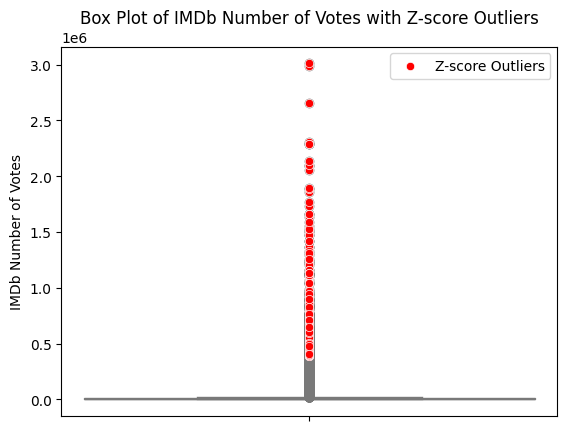

In [5]:
# Create a box plot for 'imdbNumVotes'
sns.boxplot(y=df_z['imdbNumVotes'], color='lightblue')

# Overlay outliers identified by Z-score
outliers = df_z[df_z['is_outlier']]
sns.scatterplot(y=outliers['imdbNumVotes'], x=[0]*len(outliers), color='red', label='Z-score Outliers', zorder=10)

plt.title('Box Plot of IMDb Number of Votes with Z-score Outliers')
plt.ylabel('IMDb Number of Votes')
plt.legend()
plt.show()

### Outliers Detected using IQR

In [6]:
df_iqr = df_numeric

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for imdbNumVotes
Q1 = df_iqr['imdbNumVotes'].quantile(0.25)
Q3 = df_iqr['imdbNumVotes'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries as scalar values
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
df_iqr['is_outlier'] = (df_iqr['imdbNumVotes'] < lower_bound) | (df_iqr['imdbNumVotes'] > upper_bound)

# Extract rows with outliers
df_outliers_iqr = df[df_iqr['is_outlier']]

print("\nOutliers detected using IQR:")
print(df_outliers_iqr)


Outliers detected using IQR:
                             title   type                     genres  \
0                  American Beauty  movie                      Drama   
1                The Fifth Element  movie  Action, Adventure, Sci-Fi   
2                Kill Bill: Vol. 1  movie    Action, Crime, Thriller   
3                          Jarhead  movie      Biography, Drama, War   
4                       Unforgiven  movie             Drama, Western   
...                            ...    ...                        ...   
20384                Baby Reindeer     tv           Biography, Drama   
20457          A Man on the Inside     tv              Comedy, Crime   
20496  The Great Indian Kapil Show     tv          Comedy, Talk-Show   
20544            Nobody Wants This     tv            Comedy, Romance   
20588         When the Phone Rings     tv    Drama, Mystery, Romance   

       releaseYear      imdbId  imdbAverageRating  imdbNumVotes  \
0           1999.0   tt0169547        

### IQR Outliers Visualization using Scatter Plot

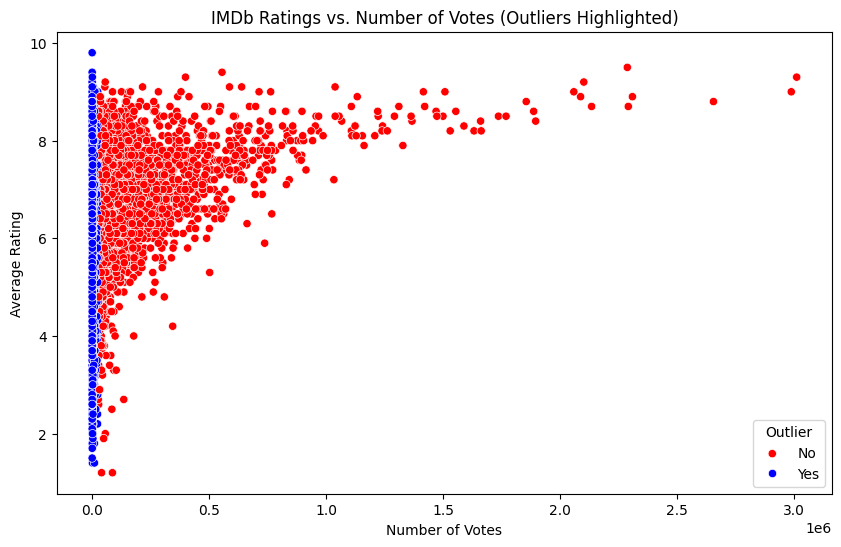

In [7]:

# Scatter Plot with Outliers Highlighted
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_iqr,
    x='imdbNumVotes', y='imdbAverageRating',
    hue='is_outlier',  # Color by outlier status
    palette={True: 'red', False: 'blue'},  # Red for outliers, blue for non-outliers
    legend='brief'
)

# Highlight outliers with annotations
for i in range(len(df_iqr)):
    if df_iqr['is_outlier'].iloc[i]:
        plt.text(
            df_iqr['imdbNumVotes'].iloc[i],
            df_iqr['imdbAverageRating'].iloc[i],
            s="", 
            fontsize=9,
            ha='right'
        )

plt.title('IMDb Ratings vs. Number of Votes (Outliers Highlighted)')
plt.xlabel('Number of Votes')
plt.ylabel('Average Rating')
plt.legend(title='Outlier', labels=['No', 'Yes'])
plt.show()

### Detecting outliers using Isolation Method

In [8]:
x = df_numeric[["imdbNumVotes", "imdbAverageRating"]]

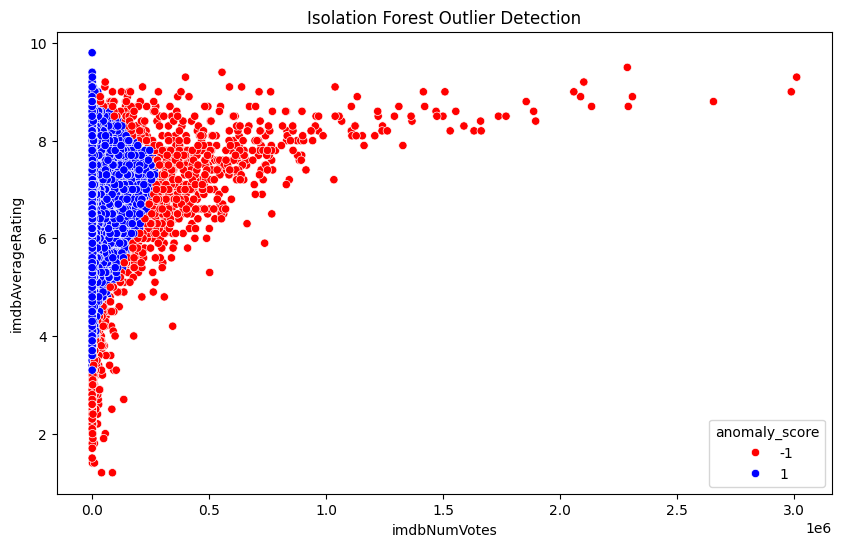

In [9]:
from sklearn.ensemble import IsolationForest

df_iso_forest = df_numeric

iso_forest = IsolationForest(contamination=0.05, random_state=42)
df_iso_forest['anomaly_score'] = iso_forest.fit_predict(df_iso_forest[['imdbNumVotes', 'imdbAverageRating']])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_iso_forest, x='imdbNumVotes', y='imdbAverageRating', hue='anomaly_score', palette=['red', 'blue'])
plt.title('Isolation Forest Outlier Detection')
plt.show()



### Comparing Count using Statistical Method and Machine Learning Method

In [10]:
# Count iqr outliers
outlier_count_iqr = df_iqr['is_outlier'].sum()
print(f'Number of outliers detected using IQR method: {outlier_count_iqr}')

# Count the number of outliers
outlier_count_iso = (df_iso_forest['anomaly_score'] == -1).sum()
print(f'Number of outliers detected using Isolation Forest: {outlier_count_iso}')


Number of outliers detected using IQR method: 3256
Number of outliers detected using Isolation Forest: 1044


### Cleaned outliers using the IQR Method

In [11]:
# Assuming df_numeric is your DataFrame containing numerical data
df_cleaned = df_numeric.copy()

# Remove outliers
df_cleaned = df_cleaned[~((df_cleaned < lower_bound) | (df_cleaned > upper_bound)).any(axis=1)]
print(f'Number of data points after removing outliers: {df_cleaned.shape[0]}')

Number of data points after removing outliers: 17621


### Performing Winsorization

In [12]:
from scipy.stats.mstats import winsorize

# Assuming df_numeric is your DataFrame containing numerical data
df_winsorized = df_numeric.copy()

# Apply Winsorization to each column (e.g., limit data to the 5th and 95th percentiles)
for column in df_winsorized.columns:
    df_winsorized[column] = winsorize(df_winsorized[column], limits=[0.05, 0.05])

print(f'Winsorized data:\n{df_winsorized.describe()}')


Winsorized data:
        releaseYear  imdbAverageRating  imdbNumVotes       z_score  \
count  20877.000000       19166.000000  1.916600e+04  19166.000000   
mean    2014.205968           6.433325  3.169361e+04      0.000011   
std       10.888187           1.002567  1.202097e+05      0.999997   
min     1982.000000           4.500000  5.200000e+01     -0.263209   
25%     2012.000000           5.700000  3.262500e+02     -0.260927   
50%     2018.000000           6.500000  1.584500e+03     -0.250460   
75%     2022.000000           7.175000  1.007350e+04     -0.179842   
max     2024.000000           9.800000  3.011183e+06     24.785711   

       anomaly_score  
count   20877.000000  
mean        0.899986  
std         0.435930  
min        -1.000000  
25%         1.000000  
50%         1.000000  
75%         1.000000  
max         1.000000  


C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' 

### Log Transformation

In [13]:
# Assuming df_numeric is your DataFrame containing numerical data
df_log_transformed = df_numeric.copy()

# Apply log transformation to each column
df_log_transformed = np.log(df_log_transformed + 1)  # Adding 1 to avoid log(0)

print(f'Log-transformed data:\n{df_log_transformed.describe()}')

Log-transformed data:
        releaseYear  imdbAverageRating  imdbNumVotes       z_score  \
count  20842.000000       19166.000000  19166.000000  19166.000000   
mean       7.607977           1.988658      7.583057     -0.132339   
std        0.007178           0.161390      2.448564      0.393753   
min        7.556951           0.788457      1.791759     -0.305981   
25%        7.607381           1.902108      5.790724     -0.302359   
50%        7.610358           2.014903      7.368655     -0.288296   
75%        7.612337           2.101067      9.217763     -0.198258   
max        7.613819           2.379546     14.917844      3.249820   

         is_outlier  anomaly_score  
count  20877.000000   2.087700e+04  
mean       0.108104           -inf  
std        0.251493            NaN  
min        0.000000           -inf  
25%        0.000000   6.931472e-01  
50%        0.000000   6.931472e-01  
75%        0.000000   6.931472e-01  
max        0.693147   6.931472e-01  


C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


### Comparing Methods

In [14]:
# Original data statistics
print('Original Data Statistics:')
print(df_numeric.describe())

# After removing outliers
print('\nAfter Removing Outliers:')
print(df_cleaned.describe())

# After Winsorization
print('\nAfter Winsorization:')
print(df_winsorized.describe())

# After Log Transformation
print('\nAfter Log Transformation:')
print(df_log_transformed.describe())


Original Data Statistics:
        releaseYear  imdbAverageRating  imdbNumVotes       z_score  \
count  20842.000000       19166.000000  1.916600e+04  1.916600e+04   
mean    2013.250744           6.395393  3.169231e+04 -1.186339e-17   
std       14.315295           1.094817  1.202100e+05  1.000000e+00   
min     1913.000000           1.200000  5.000000e+00 -2.635996e-01   
25%     2012.000000           5.700000  3.262500e+02 -2.609272e-01   
50%     2018.000000           6.500000  1.584500e+03 -2.504601e-01   
75%     2022.000000           7.175000  1.007350e+04 -1.798420e-01   
max     2025.000000           9.800000  3.011183e+06  2.478571e+01   

       anomaly_score  
count   20877.000000  
mean        0.899986  
std         0.435930  
min        -1.000000  
25%         1.000000  
50%         1.000000  
75%         1.000000  
max         1.000000  

After Removing Outliers:
        releaseYear  imdbAverageRating  imdbNumVotes       z_score  \
count  17586.000000       15910.000000  

C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' 

        releaseYear  imdbAverageRating  imdbNumVotes       z_score  \
count  20877.000000       19166.000000  1.916600e+04  19166.000000   
mean    2014.205968           6.433325  3.169361e+04      0.000011   
std       10.888187           1.002567  1.202097e+05      0.999997   
min     1982.000000           4.500000  5.200000e+01     -0.263209   
25%     2012.000000           5.700000  3.262500e+02     -0.260927   
50%     2018.000000           6.500000  1.584500e+03     -0.250460   
75%     2022.000000           7.175000  1.007350e+04     -0.179842   
max     2024.000000           9.800000  3.011183e+06     24.785711   

       anomaly_score  
count   20877.000000  
mean        0.899986  
std         0.435930  
min        -1.000000  
25%         1.000000  
50%         1.000000  
75%         1.000000  
max         1.000000  

After Log Transformation:
        releaseYear  imdbAverageRating  imdbNumVotes       z_score  \
count  20842.000000       19166.000000  19166.000000  19166.00000

C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

def train_model(df):
    # Initialize the imputer with the desired strategy, to clear null values
    imputer = SimpleImputer(strategy='mean')
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

    # Define features and target
    X = df_imputed
    y = (X['imdbAverageRating'] * X['imdbNumVotes']) / 1000  # Example target

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')

### Train Model with outliers

In [16]:
# Select numeric columns
df_numeric = df[['imdbAverageRating', 'imdbNumVotes']]
train_model(df_numeric)

Mean Squared Error: 11898.578279760819


### Training Machine Learning Model after outliers handling

In [17]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

# Define outlier criteria
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_no_outliers = df_numeric[~((df_numeric < lower_bound) | (df_numeric > upper_bound)).any(axis=1)]
train_model(df_no_outliers)

Mean Squared Error: 22.869227080896728


### Result Summarization

Based on the results on training a model with and without outliers, it has been shown that dropping outliers help prevent skewed out data and helps with normalization

**How do different outlier detection techniques impact the identification of anomalies in the datasets?**

Different outlier detection techniques have varying sensitivity and more complex outlier detection techniques cost more processing power choosing the right outlier detection technique depends on the data that is being analyzed to make sure that correct anomalies are actually being detected and avoiding false positives.

**How does the presence of outliers affect the performance of different machine learning models?**

Outliers are anomalies that are included in a set of data. These anomalies can cause data to be skewed, which might affect machine learning models that are sensitive to extreme values. These outliers can cause the model to either overfit or underfit

**How does the presence of outliers affect the performance of different machine learning models?**

Models, especially those that are sensitive to distribution of data might be affected by large anomalies cause by outliers, they can increase the rate of error of a machine learning model and reduce its accuracy

**What are the potential drawbacks of removing outliers from a datasets?**

Some of the drawback of removing outliers are the following:
- Loss of important data
- Overfitting

**If you were working with a real-word datasets, what factors would you consider before deciding to remove outliers?**

Some things to consider are the following:
- Importance of data distribution
- The target or goal of the machine learning model
- Impacts of removing or retaining outliers in the dataset

